In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
cd ..

/Share/home/shibinbin/projects/exRNA


In [61]:
import pandas as pd
import seaborn as sns
sns.set()
sns.set_style('whitegrid')
import itertools
from scipy.cluster import hierarchy
from tqdm import tqdm_notebook

In [4]:
with open('metadata/sample_ids.txt', 'r') as f:
    sample_ids = f.read().split()

rna_types = ['lncRNA', 'miRNA', 'mRNA', 'piRNA', 'snoRNA',
    'snRNA', 'srpRNA', 'tRNA', 'tucpRNA', 'vaultRNA', 'Y_RNA']
piranha_methods = ['ZeroTruncatedNegativeBinomial', 'ZeroTruncatedNegativeBinomialRegression',
    'ZeroTruncatedPoisson', 'ZeroTruncatedPoissonRegression']
piranha_bin_sizes = [10, 20, 30, 40]

In [8]:
tbed = []
for rna_type in rna_types:
    tbed.append(pd.read_table('data/annotation/tbed/{rna_type}.bed'.format(rna_type=rna_type), 
                              header=None, names=['rna_id', 'start', 'end', 'name', 'score', 'strand']))
tbed = pd.concat(tbed, axis=0)
tbed.index = tbed['rna_id']
tbed.head()

,rna_id,start,end,name,score,strand
rna_id,,,,,,
ENST00000229465.10,ENST00000229465.10,0,1655,ENST00000229465.10,0,+
ENST00000230113.4,ENST00000230113.4,0,487,ENST00000230113.4,0,+
ENST00000235290.7,ENST00000235290.7,0,1739,ENST00000235290.7,0,+
ENST00000242109.5,ENST00000242109.5,0,4283,ENST00000242109.5,0,+
ENST00000244820.2,ENST00000244820.2,0,2231,ENST00000244820.2,0,+


## Create peak matrix

In [11]:
method = piranha_methods[0]
bin_size = piranha_bin_sizes[1]
rna_id = 'ENST00000618786.1'
peak_map = pd.DataFrame(np.zeros((len(sample_ids), tbed.loc[rna_id, 'end']), dtype=np.int32),
                        index=sample_ids)
for i_sample, sample_id in enumerate(sample_ids):
    filename = 'output/call_peak_piranha/{bin_size}/{method}/{sample_id}.bed'.format(
        method=method, sample_id=sample_id, bin_size=bin_size)
    peaks = pd.read_table(filename, header=None)
    if peaks.shape[1] < 6:
        continue
    peaks = peaks[peaks.iloc[:, 0] == rna_id]
    for row in peaks.itertuples(index=False):
        peak_map.iloc[i_sample, row[1]:row[2]] = 1

In [105]:
bin_size

20

## Create bin coverage matrix

In [62]:
bincov_map = pd.DataFrame(np.zeros((len(sample_ids), tbed.loc[rna_id, 'end']), dtype=np.int32),
                        index=sample_ids)
pbar = tqdm_notebook(total=len(sample_ids)*len(rna_types))
for i_sample, sample_id in enumerate(sample_ids):
    for rna_type in rna_types:
        filename = 'output/tbin_coverage/{bin_size}/{sample_id}/{rna_type}.bed'.format(
            sample_id=sample_id, bin_size=bin_size, rna_type=rna_type)
        bincov = pd.read_table(filename, header=None)
        bincov.iloc[:, 0] = bincov.iloc[:, 0].astype('str')
        bincov = bincov[bincov.iloc[:, 0] == rna_id]
        for row in bincov.itertuples(index=False):
            bincov_map.iloc[i_sample, row[1]:row[2]] = row[4]
        del bincov
        pbar.update()
pbar.close()

HBox(children=(IntProgress(value=0, max=671), HTML(value='')))

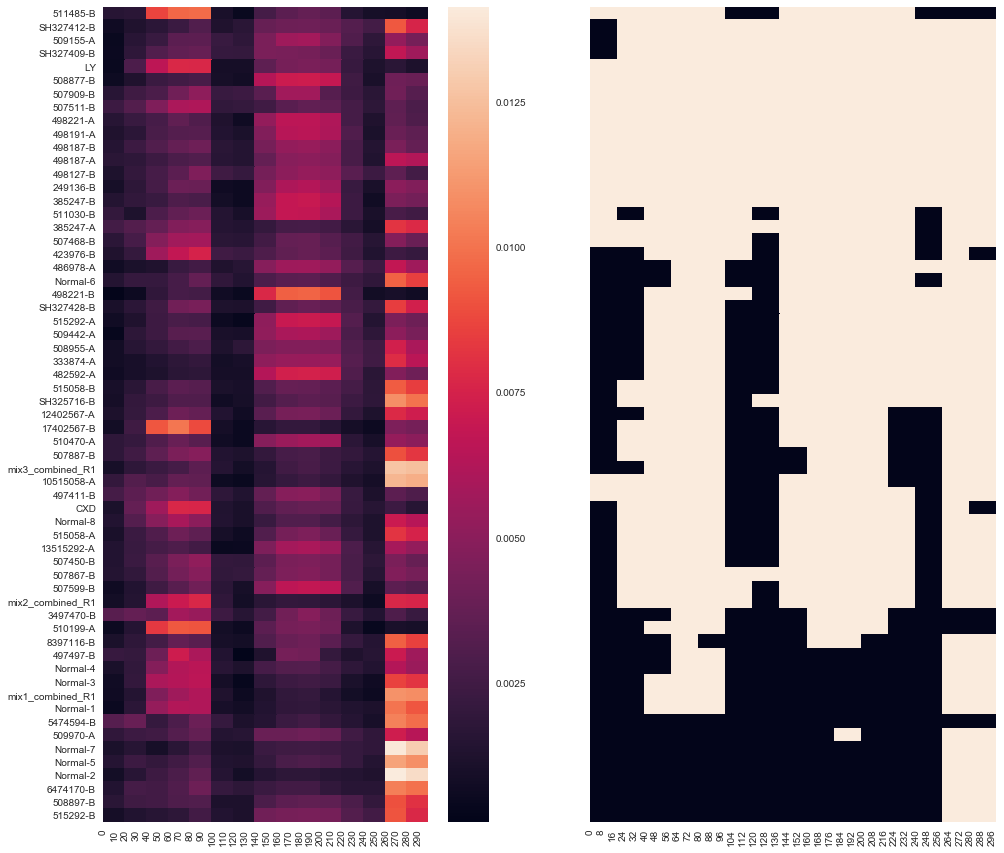

In [98]:
fig, axes = plt.subplots(1, 2, figsize=(16, 15))
#den = hierarchy.dendrogram(hierarchy.linkage(bincov_map, method='average', metric='euclidean'), no_plot=True)
den = hierarchy.dendrogram(hierarchy.linkage(peak_map, method='average', metric='euclidean'), no_plot=True)
bincov_map_sorted = bincov_map.iloc[np.array(den['ivl']).astype(np.int32)]
normalized_data = bincov_map_sorted.values/bincov_map_sorted.values.sum(axis=1, keepdims=True)
sns.heatmap(pd.DataFrame(normalized_data, index=bincov_map_sorted.index, columns=bincov_map_sorted.columns),
            ax=axes[0])

sns.heatmap(peak_map.iloc[np.array(den['ivl']).astype(np.int32)], 
            ax=axes[1], cbar=False, yticklabels=False)

In [107]:
peak_oc.values

array([17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
       17, 17, 17, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32,
       32, 32, 32, 32, 32, 32, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47,
       47, 47, 47, 47, 47, 47, 47, 47, 47, 53, 53, 53, 53, 53, 53, 53, 53,
       53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 52, 52, 52, 52, 52,
       52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 22, 22,
       22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22,
       22, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
       17, 17, 17, 17, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43,
       43, 43, 43, 43, 43, 43, 43, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48,
       48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 49, 49, 49, 49, 49, 49, 49,
       49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 47, 47, 47, 47,
       47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 39,
       39, 39, 39, 39, 39

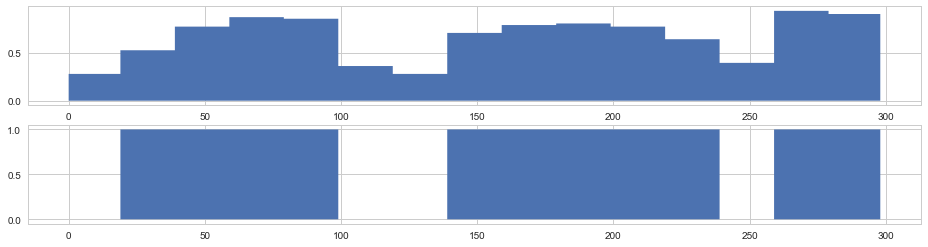

In [104]:
fig, axes = plt.subplots(2, 1, figsize=(16, 4))
peak_oc = peak_map.sum(axis=0)
axes[0].fill_between(np.arange(peak_map.shape[1]), peak_oc/peak_map.shape[0], step='pre')
axes[1].fill_between(np.arange(peak_map.shape[1]), (peak_oc/peak_map.shape[0] >= 0.5).astype(np.int32), step='pre')

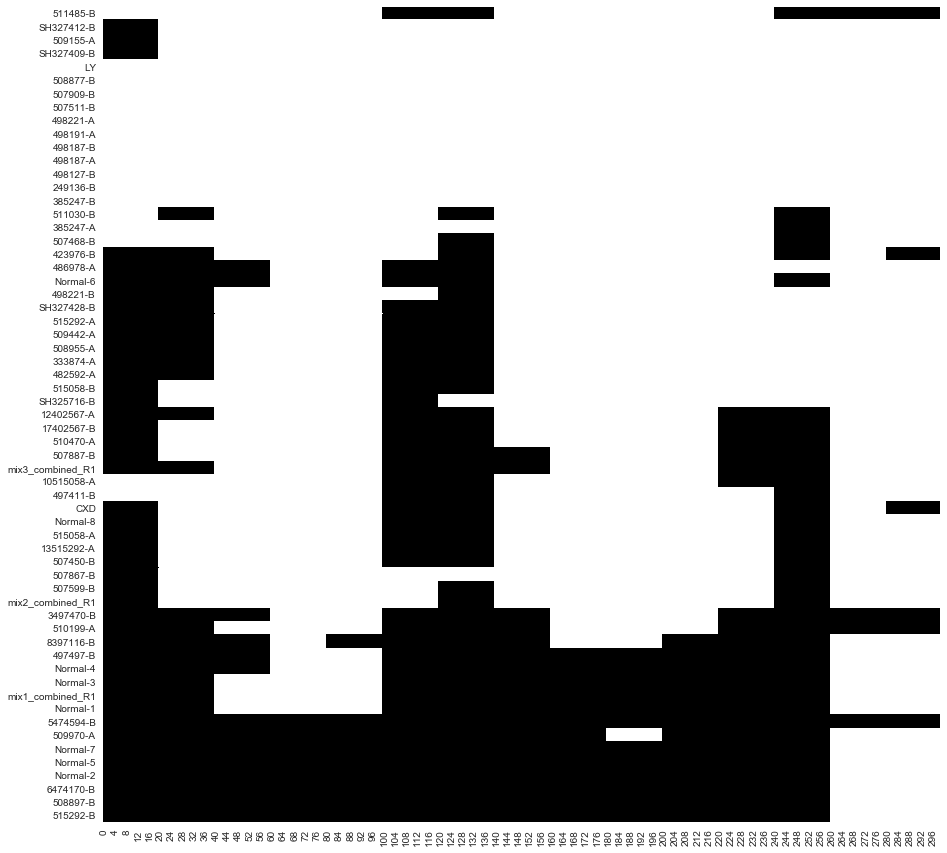

In [69]:
fig, ax = plt.subplots(figsize=(15, 15))
den = hierarchy.dendrogram(hierarchy.linkage(peak_map, method='average', metric='euclidean'), no_plot=True)
sns.heatmap(peak_map.iloc[np.array(den['ivl']).astype(np.int32)], 
            ax=ax, cmap=cm.Greys_r, cbar=False)